Due to the fact that Github doesn't render JS due to security reasons the best way to see our results full interactive is either to download the notebook and run it on your pc, or use nbviewer for our notebook. We also saved the maps in an HTML format but for our browser changing layers is not possible. [NbViewer Link to our Notebook](http://nbviewer.jupyter.org/github/martinj96/Ada2017/blob/master/Homework%203/Homework%203.ipynb??flush_cache=true)

In [1]:
import pandas as pd
import folium
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from branca.colormap import linear
from folium import FeatureGroup, LayerControl, Map, Marker
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

## Task 1: Unemployment Rate in EU Countries and Switzerland

In this task we used the datasets, which were provided from the <b>eustat</b> with code tsdec450 and from <b>amstat</b> 2_1 Arbeitslosenquoten.csv for finding the total unemployment rate for both European countries and Switzerland. 

1. For the first dataset, unemployment rates represent unemployed persons as a percentage of the labour force. The labour force is the total number of people employed and unemployed. Unemployed persons comprise persons aged 15 to 74 who were: a. without work during the reference week, b. currently available for work, i.e. were available for paid employment or self-employment before the end of the two weeks following the reference week, c. actively seeking work, i.e. had taken specific steps in the four weeks period ending with the reference week to seek paid employment or self-employment or who found a job to start later, i.e. within a period of, at most, three months.

2. For the second dataset we chose only the Arbeitlosenquote and for the time period all the months from 2010 till 2016. As the datasets provided us informations for many years, we decided to go with a sample of the years 2016,2013,2010 in order to have a more general picture and show the values in different time periods. We used also some other useful informations for the active unemployment rate, as it was also provided from the datasets.

In [2]:
#Importing data files
eustat_raw = pd.read_csv('./tsdec450.tsv', sep='\t')
eustat_data = eustat_raw.copy()

#Switzerland data for the three years 2016-2013-2010
amstat_raw = pd.read_csv('./2_1 Arbeitslosenquoten.csv',encoding = 'utf_16')
amstat_data = amstat_raw.copy()
#eustat_data

We first loaded the datasets. The format of the 2 datasets was different so we had do build different approches for building our dataframes. 
1. The first dataset from eustat was downloaded in a tsv format so we loaded it with tabs seperation.
2. The second dataset from amstat was a csv file but it had special characters in the local languages (german-french) so we use the utf-16 format.

In the amstat dataset the unemployment rate was provided per month so after dropping all the unnecessary informations, we keep only the years of the date and not the month and after that we groupby and find the mean for each year.

In [3]:
#Reset the index as is MultiIndex
amstat_data.reset_index(inplace=True)
#Drop the unnecessary columns of the dataframe
amstat_data = amstat_data.drop(['level_1','level_3','2.1 Arbeitslosenquoten'],1)
#Drop the unnecessary rows of the dataframe
amstat_data = amstat_data.drop(amstat_data.index[[0,37]])

#Keep only the years from the Description and not the months
amstat_data[str(amstat_data.columns[0])] = amstat_data[str(amstat_data.columns[0])].apply(lambda x: str(x)[-4:])

#Convert all values of the dataframe to numeric ones so we can aggregate
amstat_data[['level_0','level_2']] = amstat_data[['level_0','level_2']].apply(pd.to_numeric)

#GroupBy the dataframe according the year
amstat_data = amstat_data.groupby('level_0')['level_2'].mean()

#Make the GroupBy object a dataframe again
final_amstat = pd.DataFrame(amstat_data)

#Reset its index
final_amstat.reset_index(inplace=True)
#Rename the column names
final_amstat.rename(columns={str(final_amstat.columns[0]): 'Year'},inplace=True)
final_amstat.rename(columns={str(final_amstat.columns[1]): 'Mean'},inplace=True)


final_amstat

,Year,Mean
0,2010,3.508333
1,2013,3.150000
2,2016,3.316667


Eustat contains information for many years, but as we are only interested in recent trends we decided to analyze the most recent year - 2016, as well as 2013, 2010 to check the differences.

In [4]:
#Cleaning data files
new_slice = [str(eustat_data.columns[0])]
new_slice = new_slice + ['2010 ', '2013 ', '2016 ']

In [5]:
eustat_data = eustat_data[new_slice]
eustat_data.head(5)

,"age,unit,sex,geo\time",2010,2013,2016
0,"TOTAL,PC_ACT,T,AT",4.8,5.4,6.0
1,"TOTAL,PC_ACT,T,BE",8.3,8.4,7.8
2,"TOTAL,PC_ACT,T,BG",10.3 i,13.0,7.6
3,"TOTAL,PC_ACT,T,CY",6.3,15.9,13.0
4,"TOTAL,PC_ACT,T,CZ",7.3,7.0,4.0


After we selected the data that we wanted from the dataset, since the dataset contains many types of information we should slice it accordingly. First of all the rows of the dataset are divided in three groups. The unemployment rate is computed in three different terms.
    1. Percentage of Total Population 
    2. Percentage of active Population 
    3. Thousand People in absolute number. 
The dataframe also contains some unnecessary information for the mean value of the unemployment rate for whole EU and for countries that do not belong in EU as United States, Japan and Switzerland. All the values refer to the total population and is indepedent of genders, as it includes both. So now we will seperate the dataset in 2 equal chunks representing the different unemployment representations (total and active population). 

In [6]:
def data_preprocess(sourcedf,rawdata,bulgaria_val):
    sourcedf[str(rawdata.columns[0])] = sourcedf[str(rawdata.columns[0])].apply(lambda x: str(x)[-2:])
    sourcedf.rename(columns={str(rawdata.columns[0]): 'Country'},inplace=True)
    
    #For 2010 Bulgaria's rates weren't so trustworthy and so we change it to numeric value instead of string
    sourcedf.loc[sourcedf['Country'] == 'BG', '2010 '] = bulgaria_val 
    sourcedf['2010 '] = sourcedf['2010 '].apply(pd.to_numeric)
    
    #Map the different names between the dataset and the topojson
    sourcedf.loc[sourcedf['Country'] == 'EL', 'Country'] = 'GR'
    sourcedf.loc[sourcedf['Country'] == 'UK', 'Country'] = 'GB'

In [7]:
total_perc_data = eustat_data.iloc[0:37]
total_perc_data = total_perc_data.drop(total_perc_data.index[[7,8,12,13,21,36]])
data_preprocess(total_perc_data, eustat_data,10.3)

#Add the CH in the EU countries dataset
total_perc_data.loc[-1] = ['CH',final_amstat[final_amstat['Year'] == 2010]['Mean'][0] ,final_amstat[final_amstat['Year'] == 2013]['Mean'][1],final_amstat[final_amstat['Year'] == 2016]['Mean'][2]]
total_perc_data.index =total_perc_data.index + 1
total_perc_data = total_perc_data.sort_index()
#total_perc_data.head

In [8]:
active_perc_data = eustat_data.iloc[37:72]
active_perc_data = active_perc_data.drop([44,45,49,50])
data_preprocess(active_perc_data, eustat_data,6.0)
#active_perc_data.head(5)

1. EL in the dataset refers to Greece but in the topojson we have GR so we need to map it to the json id.
2. UK in the dataset refers to United Kingdom but in the topojson we have GB.

As the dataset was preproprecessed next step was to display the dataset on the map. In order to do that, we load the topojson files. In order to show the difference between the consecutive years we decided not to proceed with the choropleth function, but to define layers on our map to make it interactive. For the coloring we used the colormap function, but as arguments we used the min-max values of all the years tested. We did this because if we were scaling again and again for different years the result would not change as the color scale would be reinitialized. So we defined the function below to find the minimum and maximum values.

In [9]:
def find_min_data(df):
    minimum = df['2016 '].max()
    for i in ['2010 ', '2013 ']:
        if df[i].min() < minimum:
            minimum = df[i].min()
    return minimum
    
def find_max_data(df):
    maximum = df['2016 '].min()
    for i in ['2010 ', '2013 ']:
        if df[i].max() > maximum:
            maximum = df[i].max()
    return maximum

We load the json file and we create the initial map.

In [10]:
state_geo = r'europe.topojson.json'
geo_json_data = json.load(open(state_geo))

un_map = folium.Map(location=[54.5260, 15.2551], zoom_start=3)

We create a function that will scale our selected pallete in the colors with lower-bound the minimum value of the 3 years and maximum value accordingly. We thought that as the unemployment is something negative we should represent higher values of unemployment with deep red color and lower rates with whiter colors. We tried all combinations and we found that OrRd was the most appropriate choice in our occasion.

In [11]:
colormap = linear.OrRd.scale(find_min_data(total_perc_data),find_max_data(total_perc_data))

In order to avoid repeativeness we create a function that will create with the necessary arguments the different levels of our map depending the year that we are referring to.

In [12]:
def create_map_layers(source_map,data_dict,layer_name,topojson):
    folium.TopoJson(
        topojson,
        object_path='objects.europe',
        name=layer_name,
        style_function=lambda feature: {
            'fillColor': colormap(data_dict[feature['id']]) if feature['id'] in data_dict.keys() else '#d3d3d3',
            'color': 'black',
            'weight': 0,
            'dashArray': '5, 5',
            'fillOpacity': 1,
        },
        control = True
    ).add_to(source_map)

In [13]:
total_perc_data_dict = total_perc_data.set_index('Country')['2016 ']
active_perc_data_dict = active_perc_data.set_index('Country')['2016 ']
total_perc_data_dict4 = total_perc_data.set_index('Country')['2013 ']
total_perc_data_dict5 = total_perc_data.set_index('Country')['2010 ']

create_map_layers(un_map,total_perc_data_dict,'2016',geo_json_data)
create_map_layers(un_map,total_perc_data_dict4,'2013',geo_json_data)
create_map_layers(un_map,total_perc_data_dict5,'2010',geo_json_data)

After we added the layers of the different years to the map we noticed that the Folium has no option to show each layer seperately and in this way the colors are merged. So to avoid that we chose the opacity of the layers to be 1 in order for the last layer on the map to be visible, without the others beneath to affect it. In this way the reader can change the coloring of the map according the year that he wants to observe.

In order to make our presentation even more interactive after analyzing the toolbox that folium provides, we decided to put some markers in each countries' capital in order to show (apart from the colors) also the numbers of unemployment rate for each country, but only for the most recent year (2016). We also added in the popup text the active population unemployment rate for completeness. We could also add the other years, but as popups have some limitations the result would not be eye-catching.

In [14]:
fg = FeatureGroup(name='Extra data')
eu_countries_list = [([37.59,  23.44],'Greece','GR'),([48.21,  16.37],'Austria','AT'),([50.85 ,  4.35],'Belgium','BE'),
                     ([42.70,  23.32],'Bulgaria','BG'),([35.17,  33.37],'Cyprus','CY'),([50.09, 14.42],'Czech','CZ'),
                     ([52.52, 13.41],'Germany','DE'),([55.68, 12.57],'Denmark','DK'),([59.44, 24.75],'Estonia','EE'),
                     ([40.42,-3.7],'Spain','ES'),([60.17, 24.94],'Finland','FI'),([48.85, 2.35],'France','FR'),
                     ([45.81,  15.98],'Croatia','HR'),([47.5 , 19.04],'Hungary','HU'),([53.33, -6.25],'Ireland','IE'),
                     ([64.14, -21.9],'Iceland','IS'),([41.89, 12.48],'Italy','IT'),([54.69, 25.28],'Lithuania','LT'),
                     ([49.61, 6.13],'Luxemburg','LU'),([56.95, 24.11],'Latvia','LV'),([35.9, 14.51],'Malta','MT'),
                     ([52.37, 4.89],'Netherlands','NL'),([59.91, 10.75],'Norway','NO'),([52.23,21.01],'Poland','PL'),
                     ([38.72,-9.13],'Portugal','PT'),([44.43,26.11],'Romania','RO'),([59.33,18.06],'Sweden','SE'),
                     ([46.05,14.51],'Slovenia','SI'),([48.15,17.11],'Slovakia','SK'),([38.96, 35.24],'Turkey','TR'),
                     ([51.51,-0.13],'Great Britain','GB'),([46.8182, 8.2275],'Switzerland','CH')]
def cond_active(df,abbriev):
    if abbriev in df.keys():
        return str(df[abbriev])
    else: return "-"

def popup_text(country,abbriev,dfdict = total_perc_data_dict, dfdict1 = active_perc_data_dict):
    return country + " 2016" +" := " +"Total:" + str(dfdict[abbriev])+" | "+"Active:"+ cond_active(dfdict1,abbriev)

for i in eu_countries_list:
    folium.Marker(i[0],popup=popup_text(i[1],i[2]),icon=folium.Icon(color='green',icon='info-sign')).add_to(fg)

fg.add_to(un_map)
folium.LayerControl().add_to(un_map)

un_map.save('eu-ch-unemployment.html')
un_map

The map in full size can be found in the link. [European-Switzerland Unemployment rates](https://rawgit.com/martinj96/Ada2017/master/Homework%203/eu-ch-unemployment.html)

## Task 2: Unemployment rates in Switzerland

This second task caused a fair amount of confusion and a large debate over how unemployment rates are calculated in Switzerland, what is included and what is not. And it wasn't beneficial that the definitions were available only in French, Italian or German, which are not mother tongues for many.

After a prolonged data examination and reading about the attributes' meaning, we decided it would be best to first summarise our findings here and set up a common ground before proceeding with the presentation of results. We used the French version of the dataset and the definitions provided by Amstat.

### Definitions:

* <b>Taux de chômage</b> = <i>Unemployment ratio</i> -> Number of registered unemployed at the reference day (last day of the month) divided by the number of active persons, multiplied by 100.
$$ unemployment\_ratio = \frac{\#registered\_unemployed}{\#active\_persons} $$


* <b>Chômeurs inscrits</b> = <i>Registered unemployed</i> -> Persons advertised at regional employment agencies, who are unemployed and immediately available for placement. It does not matter whether they are receiving unemployment benefits or not.


* <b>Demandeurs d'emploi inscrits non-chômeurs</b> = <i>Registered employed jobseekers</i> -> Jobseekers who are registered with the regional employment offices however who, unlike the unemployed, are not immediately available for placement or have a job. The number of unemployed job-seekers is the difference between the number of registered job-seekers and the number of unemployed. They are further classified into 4 categories.
$$ registered\_employed\_jobseekers = \#registered\_unemployed\_jobseekers - \#registered\_unemployed $$


* <b>Demandeurs d'emploi inscrits</b> = <i>Registered jobseekers</i> -> All job seekers, unemployed and non-unemployed, who are registered with regional employment agencies and are looking for work.

The data we obtained from Amstat is very recent. The last available month is September 2017.

In order to have a clearer picture of the situation on the Swiss unemployment market, we decided to take a period of 13 months, from September 2016 to September 2017 and average the figures. This will show us a less biased trend over a larger period in which seasonal peaks or drops will balance. Just for comparison, we visualise the data for September 2017 separately as well, so they can be compared to the overall annual average.

In [15]:
# Load the data
raw_data = pd.read_csv('Taux-de-chomage-annuel.csv', sep=',', encoding='utf_16', header=[1, 2], skipinitialspace=True, tupleize_cols=True)
raw_data.columns = pd.MultiIndex.from_tuples(raw_data.columns)
# The dataset contains one row for each canton
raw_data.head(5)

Canton    Mois  Septembre 2016                            \
  Canton nom en francais Mesures Taux de chômage Coefficients de variation   
0                 Zurich     NaN             3.6                         A   
1                  Berne     NaN             2.6                         A   
2                Lucerne     NaN             1.9                         A   
3                    Uri     NaN             0.9                         C   
4                 Schwyz     NaN             1.6                         A   

                                                                          \
  Chômeurs inscrits Demandeurs d'emploi Demandeurs d'emploi non chômeurs   
0            29'462              36'233                            6'771   
1            14'516              19'218                            4'702   
2             4'285               7'126                            2'841   
3               179                 332                              153   
4             1'433               2'182                              749   

                                          \
  Demandeurs d'emploi non chômeurs - PET   
0                                    353   
1                                    334   
2                                    405   
3                                     35   
4                                    128   

                                             \
  Demandeurs d'emploi non chômeurs - autres   
0                                     2'392   
1                                     2'073   
2                                     1'096   
3                                        59   
4                                       326   

                                                                    \
  Demandeurs d'emploi non chômeurs - Reconversion/perfectionnement   
0                                                 89                 
1                                                113                 
2                                                231                 
3                                                  1                 
4                                                  2                 

             ...                                 Total                    \
             ...             Coefficients de variation Chômeurs inscrits   
0            ...                                     A           385'120   
1            ...                                     A           195'949   
2            ...                                     A            56'210   
3            ...                                     C             2'609   
4            ...                                     A            20'198   

                                                        \
  Demandeurs d'emploi Demandeurs d'emploi non chômeurs   
0             476'712                           91'592   
1             257'845                           61'896   
2              94'895                           38'685   
3               4'646                            2'037   
4              30'545                           10'347   

                                          \
  Demandeurs d'emploi non chômeurs - PET   
0                                  4'326   
1                                  3'896   
2                                  5'512   
3                                    403   
4                                  1'903   

                                             \
  Demandeurs d'emploi non chômeurs - autres   
0                                    33'392   
1                                    27'990   
2                                    14'756   
3                                       643   
4                                     4'673   

                                                                    \
  Demandeurs d'emploi non chômeurs - Reconversion/perfectionnement   
0                                              1'343                 
1                  

Some of the filters could have been unchecked in the first place, on the Amstat report creation website. However, we wanted to have a better insight of how the figures and attributes are related to eachother.

In [16]:
# Drop all columns that contain only NaN values
raw_data = raw_data.dropna(axis=1, how='all')

# Delete the aggregated total value at the end (last row) -> leaves only the canton values
raw_data = raw_data.drop(26, axis=0)

# Reindex the dataset -> canton names are unique, they can be used as indices
raw_data = raw_data.set_index(raw_data['Canton']['Canton nom en francais'])
raw_data.head(5)

Canton  Septembre 2016  \
                       Canton nom en francais Taux de chômage   
Canton nom en francais                                          
Zurich                                 Zurich             3.6   
Berne                                   Berne             2.6   
Lucerne                               Lucerne             1.9   
Uri                                       Uri             0.9   
Schwyz                                 Schwyz             1.6   

                                                                    \
                       Coefficients de variation Chômeurs inscrits   
Canton nom en francais                                               
Zurich                                         A            29'462   
Berne                                          A            14'516   
Lucerne                                        A             4'285   
Uri                                            C               179   
Schwyz                                         A             1'433   

                                                                             \
                       Demandeurs d'emploi Demandeurs d'emploi non chômeurs   
Canton nom en francais                                                        
Zurich                              36'233                            6'771   
Berne                               19'218                            4'702   
Lucerne                              7'126                            2'841   
Uri                                    332                              153   
Schwyz                               2'182                              749   

                                                               \
                       Demandeurs d'emploi non chômeurs - PET   
Canton nom en francais                                          
Zurich                                                    353   
Berne                                                     334   
Lucerne                                                   405   
Uri                                                        35   
Schwyz                                                    128   

                                                                  \
                       Demandeurs d'emploi non chômeurs - autres   
Canton nom en francais                                             
Zurich                                                     2'392   
Berne                                                      2'073   
Lucerne                                                    1'096   
Uri                                                           59   
Schwyz                                                       326   

                                                                                         \
                       Demandeurs d'emploi non chômeurs - Reconversion/perfectionnement   
Canton nom en francais                                                                    
Zurich                                                                 89                 
Berne                                                                 113                 
Lucerne                                                               231                 
Uri                                                                     1                 
Schwyz                                                                  2                 

                                                                              \
                       Demandeurs d'emploi non chômeurs - gain intermédiaire   
Canton nom en francais                                                         
Zurich                                                              3'937      
Berne                                                               2'182      
Lucerne                                                             1'109      
Uri                                              

In [17]:
# Take only the unemployment rates for a period of 13 months (September 2016-September 2017)
unemployment_rates = raw_data.xs(key='Taux de chômage', axis=1, level=1)
unemployment_rates.head(5)

,Septembre 2016,Octobre 2016,Novembre 2016,Décembre 2016,Janvier 2017,Février 2017,Mars 2017,Avril 2017,Mai 2017,Juin 2017,Juillet 2017,Août 2017,Septembre 2017,Total
Canton nom en francais,,,,,,,,,,,,,,
Zurich,3.6,3.6,3.7,3.8,3.9,3.9,3.8,3.6,3.5,3.4,3.4,3.4,3.3,3.6
Berne,2.6,2.6,2.8,3.0,3.0,3.0,2.9,2.7,2.6,2.4,2.4,2.5,2.4,2.7
Lucerne,1.9,1.9,2.0,2.2,2.2,2.2,2.0,1.9,1.8,1.7,1.7,1.8,1.7,1.9
Uri,0.9,1.0,1.1,1.3,1.5,1.4,1.3,1.2,1.0,0.8,0.7,0.6,0.6,1.0
Schwyz,1.6,1.7,1.8,1.9,2.0,2.0,1.9,1.8,1.7,1.6,1.7,1.7,1.7,1.8


In [18]:
# Necessary to connect the map overlay features to the dataset columns
canton_id_mappings = {
    'Zurich': 'ZH',
    'Berne': 'BE',
    'Lucerne': 'LU',
    'Uri': 'UR',
    'Schwyz': 'SZ',
    'Obwald': 'OW',
    'Nidwald': 'NW',
    'Glaris': 'GL', 
    'Zoug': 'ZG', 
    'Fribourg': 'FR', 
    'Soleure': 'SO', 
    'Bâle-Ville': 'BS', 
    'Bâle-Campagne': 'BL',
    'Schaffhouse': 'SH', 
    'Appenzell Rhodes-Extérieures': 'AR',
    'Appenzell Rhodes-Intérieures': 'AI', 
    'St-Gall': 'SG', 
    'Grisons': 'GR', 
    'Argovie': 'AG',
    'Thurgovie': 'TG', 
    'Tessin': 'TI', 
    'Vaud': 'VD', 
    'Valais': 'VS', 
    'Neuchâtel': 'NE', 
    'Genève': 'GE', 
    'Jura': 'JU'
}

# Create a pandas dataframe based on the dictionary data
mapping_df = pd.DataFrame.from_dict(canton_id_mappings, orient='index')
mapping_df.columns = ['Id']
# Merge the unemployment rates table and the canton IDs in a single dataframe
unemployment_rates = unemployment_rates.merge(mapping_df, how='outer', left_index=True, right_index=True)
unemployment_rates.head(5)

,Septembre 2016,Octobre 2016,Novembre 2016,Décembre 2016,Janvier 2017,Février 2017,Mars 2017,Avril 2017,Mai 2017,Juin 2017,Juillet 2017,Août 2017,Septembre 2017,Total,Id
Canton nom en francais,,,,,,,,,,,,,,,
Zurich,3.6,3.6,3.7,3.8,3.9,3.9,3.8,3.6,3.5,3.4,3.4,3.4,3.3,3.6,ZH
Berne,2.6,2.6,2.8,3.0,3.0,3.0,2.9,2.7,2.6,2.4,2.4,2.5,2.4,2.7,BE
Lucerne,1.9,1.9,2.0,2.2,2.2,2.2,2.0,1.9,1.8,1.7,1.7,1.8,1.7,1.9,LU
Uri,0.9,1.0,1.1,1.3,1.5,1.4,1.3,1.2,1.0,0.8,0.7,0.6,0.6,1.0,UR
Schwyz,1.6,1.7,1.8,1.9,2.0,2.0,1.9,1.8,1.7,1.6,1.7,1.7,1.7,1.8,SZ


In [19]:
switzerland_location = [46.8182, 8.2275]
geo_path = r'ch-cantons.topojson.json'
geo_json_data = json.load(open(geo_path))
    
def draw_swiss_choropleth_map(data_df, map_name, legend_caption, columns, key, filename):
    swiss_map = folium.Map(location=switzerland_location, tiles='cartodbpositron', zoom_start=8)
    
    swiss_map.choropleth(geo_data=geo_json_data, data=data_df, name=map_name, columns=columns, 
                         key_on=key, topojson='objects.cantons', fill_color='OrRd', 
                         fill_opacity=0.7, line_opacity=0.2, legend_name=legend_caption)
    
    folium.LayerControl().add_to(swiss_map)
    
    swiss_map.save(filename)
    return swiss_map

Annual average unemployment rate for the period September 2016-September 2017 (inclusive)

In [20]:
unemployment_map = draw_swiss_choropleth_map(unemployment_rates, 'Unemployement rates (annual average)',
                                            'Annual average unemployment rate (%)', ['Id', 'Total'], 'feature.id',
                                            'annual-unemployment-map.html')

The map in full size can be found on the following link: [Annual average unemployment rate map](https://cdn.rawgit.com/martinj96/Ada2017/637d5020/Homework%203/annual-unemployment-map.html)

In [21]:
unemployment_map

Even though the number of bins in which the data is split is rather small, diverging colours are a good option to achieve maximal contrast. Usually a diverging colour scheme is used to emphasize a central value and how the other points or areas differ from it, which is not the case here, but this colour palette makes the map very expressive about the value of the unemployment rate for each canton, makes it very easy to compare the relative differences in unemployment rates and makes the canton borders easily differentiable.

The use of green and red is easily justified by refering to the colour wheel, where one can see that these two colours are complementary, hence bearing the highest amount of contrast. This contributes to the nice distinction of cantonal borders even without emphasising the border lines.

The 26 cantons are split into 6 bins, according to their respective unemployment rate. Based on the map, the cantons of Geneva and Neuchatel have the highest annual unemployment average, as opposed to the predominantly Swiss German cantons in the East, which are very low on the scale. The majority of those have an unemployment rate of 0.9-2.5% for the given period of 13 months, with the best one being Obwald. 

The grouping of cantons into bins is done in a way that allows for a minimal difference between the values that fall into a group. There is no bin that has a larger percent point difference than 0.6 between actual data points.

The unemployment rates per canton for September 2017. Map given to serve as a comparison to the annual average rates.

In [22]:
unemployment_map_september_2017 = draw_swiss_choropleth_map(unemployment_rates, 'Unemployement rates (September 2017)',
                                            'September 2017: Unemployment rate (%)', ['Id', 'Septembre 2017'], 'feature.id',
                                            'annual-unemployment-map-september-2017.html')

The map in full size can be found on the following link: [Annual unemployment rate map - September 2017](https://rawgit.com/martinj96/Ada2017/master/Homework%203/annual-unemployment-map-september-2017.html)

In [23]:
unemployment_map_september_2017

The September 2017 results show a general drop of unemploymend rate compared to the annual average. This is visible from the changed range of values, which indicates a notable improvement. There is not a single canton whose September 2017 score is not better than the annual average. The 'worst' case is Fribourg where there is no difference, i.e. the unemployment rate in September 2017 was equal to the mean value. The highest difference can be noticed for the cantons of Valais (notice the change of colour on the map) and Neuchatel, with 0.9 and 0.7 percent points change, respectively. That now puts Geneva on the tail and Uri in the lead, with Obwald being close behind it.

#### Redefining the unemployment rate

The instructions of task 2 are somewhat misleading in terms of the definition of unemployment rate and what exactly is included in the computation formula. As we gave clear definition of the terms used in the dataset at the beginning, we will follow those to derive the data necessary for comparison between multiple potential ways of calculating the unemployment rate, including or excluding certain social groups.

Since the category of `registered unemployed` cannot be subdivided according to the definition, we use the superset `registered unemployed jobseekers` in order to show a different way of computing the ratio.

But, according to the aforementioned formula, we need the number of active persons, i.e. the active population per canton in order to compute the new rate. But since we know the rate and the number of registered unemployed per month, we can use the above formula to calculate the active population value for a particular month. In the end we simply average the 13 values to obtain the final one which will be plotted, i.e. represented on the map.

In [24]:
# Subset the original dataset keeping only the values needed to compute the new unemployment ratio
level_ind = raw_data.columns.get_level_values(1)
cols_of_interest = (level_ind == 'Taux de chômage') | (level_ind == 'Chômeurs inscrits') | (level_ind == 'Demandeurs d\'emploi') | (level_ind == 'Demandeurs d\'emploi non chômeurs')
unemployment_subset = raw_data.iloc[:, cols_of_interest].drop('Total', axis=1, level=0)
unemployment_subset.head(5)

Septembre 2016                                        \
                       Taux de chômage Chômeurs inscrits Demandeurs d'emploi   
Canton nom en francais                                                         
Zurich                             3.6            29'462              36'233   
Berne                              2.6            14'516              19'218   
Lucerne                            1.9             4'285               7'126   
Uri                                0.9               179                 332   
Schwyz                             1.6             1'433               2'182   

                                                           Octobre 2016  \
                       Demandeurs d'emploi non chômeurs Taux de chômage   
Canton nom en francais                                                    
Zurich                                            6'771             3.6   
Berne                                             4'702             2.6   
Lucerne                                           2'841             1.9   
Uri                                                 153             1.0   
Schwyz                                              749             1.7   

                                                              \
                       Chômeurs inscrits Demandeurs d'emploi   
Canton nom en francais                                         
Zurich                            29'768              36'691   
Berne                             14'888              19'836   
Lucerne                            4'294               7'246   
Uri                                  194                 343   
Schwyz                             1'474               2'247   

                                                          Novembre 2016  \
                       Demandeurs d'emploi non chômeurs Taux de chômage   
Canton nom en francais                                                    
Zurich                                            6'923             3.7   
Berne                                             4'948             2.8   
Lucerne                                           2'952             2.0   
Uri                                                 149             1.1   
Schwyz                                              773             1.8   

                                                       ...                 \
                       Chômeurs inscrits               ...                  
Canton nom en francais                                 ...                  
Zurich                            30'651               ...                  
Berne                             15'753               ...                  
Lucerne                            4'429               ...                  
Uri                                  218               ...                  
Schwyz                             1'557               ...                  

                              Juillet 2017                                   \
                       Demandeurs d'emploi Demandeurs d'emploi non chômeurs   
Canton nom en francais                                                        
Zurich                              35'112                            7'120   
Berne                               18'442                            4'809   
Lucerne                              6'805                            2'930   
Uri                                    265                              136   
Schwyz                               2'232                              785   

                             Août 2017                                        \
                       Taux de chômage Chômeurs inscrits Demandeurs d'emploi   
Canton nom en francais                                                         
Zurich                             3.4            27'514              34'542   
Berne                              2.5            13'829              18'393   
Lucerne           

In [25]:
def convert_column_to_numeric(df, level1_col, level2_col):
    for level1 in level1_col:
        for level2 in level2_col:
            # Remove the thousands separator
            df[level1, level2].replace('\'', '', regex=True, inplace=True)
            # Parse the string values into numbers
            df[level1, level2] = pd.to_numeric(df[level1, level2])
            
    return df

In [26]:
# The original dataset has a MultiIndex, therefore it is necessary to have the entire index hierarchy
level1_cols = set(unemployment_subset.columns.get_level_values(0))
level2_cols = ['Chômeurs inscrits', 'Demandeurs d\'emploi', 'Demandeurs d\'emploi non chômeurs']
convert_column_to_numeric(unemployment_subset, level1_cols, level2_cols).head(5)

Septembre 2016                                        \
                       Taux de chômage Chômeurs inscrits Demandeurs d'emploi   
Canton nom en francais                                                         
Zurich                             3.6             29462               36233   
Berne                              2.6             14516               19218   
Lucerne                            1.9              4285                7126   
Uri                                0.9               179                 332   
Schwyz                             1.6              1433                2182   

                                                           Octobre 2016  \
                       Demandeurs d'emploi non chômeurs Taux de chômage   
Canton nom en francais                                                    
Zurich                                             6771             3.6   
Berne                                              4702             2.6   
Lucerne                                            2841             1.9   
Uri                                                 153             1.0   
Schwyz                                              749             1.7   

                                                              \
                       Chômeurs inscrits Demandeurs d'emploi   
Canton nom en francais                                         
Zurich                             29768               36691   
Berne                              14888               19836   
Lucerne                             4294                7246   
Uri                                  194                 343   
Schwyz                              1474                2247   

                                                          Novembre 2016  \
                       Demandeurs d'emploi non chômeurs Taux de chômage   
Canton nom en francais                                                    
Zurich                                             6923             3.7   
Berne                                              4948             2.8   
Lucerne                                            2952             2.0   
Uri                                                 149             1.1   
Schwyz                                              773             1.8   

                                                       ...                 \
                       Chômeurs inscrits               ...                  
Canton nom en francais                                 ...                  
Zurich                             30651               ...                  
Berne                              15753               ...                  
Lucerne                             4429               ...                  
Uri                                  218               ...                  
Schwyz                              1557               ...                  

                              Juillet 2017                                   \
                       Demandeurs d'emploi Demandeurs d'emploi non chômeurs   
Canton nom en francais                                                        
Zurich                               35112                             7120   
Berne                                18442                             4809   
Lucerne                               6805                             2930   
Uri                                    265                              136   
Schwyz                                2232                              785   

                             Août 2017                                        \
                       Taux de chômage Chômeurs inscrits Demandeurs d'emploi   
Canton nom en francais                                                         
Zurich                             3.4             27514               34542   
Berne                              2.5             13829               18393   
Lucerne           

In [27]:
# Compute the new features
for col_name in level1_cols:  
    active_population = unemployment_subset[col_name, 'Chômeurs inscrits'] / unemployment_subset[col_name, 'Taux de chômage'] * 100
    unemployment_subset[col_name, 'Personnes actives'] = pd.to_numeric(round(active_population), downcast='integer')
    
    unemployment_ratio_all = unemployment_subset[col_name, 'Demandeurs d\'emploi'] / unemployment_subset[col_name, 'Personnes actives'] * 100
    unemployment_subset[col_name, 'Taux de chômage tous'] = unemployment_ratio_all
    
    unemployment_subset = unemployment_subset.sort_index(axis=1)

unemployment_subset['Total', 'Taux de chômage tous'] = unemployment_subset.loc[:, unemployment_subset.columns.get_level_values(1) == 'Taux de chômage tous'].mean(axis=1)
unemployment_subset.head(5)

Août 2017                      \
                       Chômeurs inscrits Demandeurs d'emploi   
Canton nom en francais                                         
Zurich                             27514               34542   
Berne                              13829               18393   
Lucerne                             3992                6853   
Uri                                  123                 267   
Schwyz                              1466                2240   

                                                                           \
                       Demandeurs d'emploi non chômeurs Personnes actives   
Canton nom en francais                                                      
Zurich                                             7028            809235   
Berne                                              4564            553160   
Lucerne                                            2861            221778   
Uri                                                 144             20500   
Schwyz                                              774             86235   

                                                                   Avril 2017  \
                       Taux de chômage Taux de chômage tous Chômeurs inscrits   
Canton nom en francais                                                          
Zurich                             3.4             4.268476             29542   
Berne                              2.5             3.325078             15322   
Lucerne                            1.8             3.090027              4315   
Uri                                0.6             1.302439               228   
Schwyz                             1.7             2.597553              1580   

                                                                             \
                       Demandeurs d'emploi Demandeurs d'emploi non chômeurs   
Canton nom en francais                                                        
Zurich                               36610                             7068   
Berne                                19882                             4560   
Lucerne                               7303                             2988   
Uri                                    394                              166   
Schwyz                                2389                              809   

                                                 ...           \
                       Personnes actives         ...            
Canton nom en francais                           ...            
Zurich                            820611         ...            
Berne                             567481         ...            
Lucerne                           227105         ...            
Uri                                19000         ...            
Schwyz                             87778         ...            

                          Septembre 2016                                       \
                       Personnes actives Taux de chômage Taux de chômage tous   
Canton nom en francais                                                          
Zurich                            818389             3.6             4.427357   
Berne                             558308             2.6             3.442186   
Lucerne                           225526             1.9             3.159724   
Uri                                19889             0.9             1.669264   
Schwyz                             89562             1.6             2.436301   

                          Septembre 2017                      \
                       Chômeurs inscrits Demandeurs d'emploi   
Canton nom en francais                                         
Zurich                             27225               34156   
Berne                              13658               18385   
Lucerne                             3885                6756   
Uri                                  112                 257   
S

In [28]:
# Merge the unemployment rates and the canton IDs in a single dataframe
map_data = unemployment_subset['Total'].merge(mapping_df, how='outer', left_index=True, right_index=True)
map_data.head(5)

,Taux de chômage tous,Id
Canton nom en francais,,
Zurich,4.465839,ZH
Berne,3.532383,BE
Lucerne,3.245896,LU
Uri,1.836383,UR
Schwyz,2.687822,SZ


In [29]:
unemployment_map_annual_all = draw_swiss_choropleth_map(map_data, 'Unemployement rates including employed jobseekers (annual average)',
                                            'Unemployment rate including employed jobseekers (%)', ['Id', 'Taux de chômage tous'], 'feature.id',
                                            'annual-unemployment-annual-all.html')

The map in full size can be found on the following link: [Annual unemployment rate counting employed jobseekers](https://rawgit.com/martinj96/Ada2017/master/Homework%203/annual-unemployment-annual-all.html)

In [30]:
unemployment_map_annual_all

Naturally, when adding a particular group of people such as the registered employed jobseekers to the definition of unemployed people, the rate goes up in absolute terms, as expected. However, the majority of the cantons doesn't change significantly change their rank. For most of them the new calculation method of the rate just introduced a certain shift. Observing the data, the largest 'jump' in the values can be noticed for Fribourg, Tessin (Ticino) and Jura, with over 2 percent points difference.

This map representation shows a tendency of the Eastern cantons towards the overall average, which was not the case for the annual average rate computed previously, where they were among the best in terms of unemployment rate. The relative position of the French-speaking cantons and Tessin (Ticino). The most notably high unemployment rates are still observed in Geneva and Neuchatel.

## Task 3: 

Since in the first part of the exercise we are asked to show to difference between two categories on the came geographic location, it is decided to find the rate difference between both categories in that canton and present it on a choropleth map. The reason that we go with it is that the color changes for different values of the difference which we want to emphasis, will be easily observed.

Some helper functions.

In [31]:
# Separates the attributes that will be used for the binning and removes the unneeded rows
def get_clean_flattened_columns(df, meta_columns):
    metadata = df[meta_columns]
    metadata.columns = metadata.columns.droplevel(1) # Flatten the index
    metadata = metadata.replace('Total', np.NAN).dropna()
    return metadata
    
# Processed the dataset in a way that keeps the attributes used for binning as index and nationalities as columns
# (flattens index and pivots rows)
def helper_function(df, meta_columns, yearly_average, value_column):
    metadata = get_clean_flattened_columns(df, meta_columns)
    
    sub_df = metadata.join(yearly_average)
    
    meta_columns.remove('Nationalité')
    pivot_df = sub_df.pivot_table(values=value_column, index=meta_columns, columns='Nationalité')
    return pivot_df

The datased used is obtained from the unemployement rate section on Amstat with the option to group according to nationality and canton (according to the afore discussed reasons, we use the exact time period as in the previous exercise). That means that for every month we have "Taux de chômage" column which is the monthly value that we seek, evenmore it has a first level index "Total" for which the second level index "Taux de chômage" is the average value for the whole time period.

In [32]:
nationality_df = pd.read_csv(filepath_or_buffer="nationality_rate.csv", encoding='utf-16', header=[0,1])
nationality_df.head()

Canton Nationalité    Mois  Septembre 2016                    \
                       Mesures Taux de chômage Chômeurs inscrits   
0   Zurich   Etrangers     NaN             5.7            13'016   
1   Zurich     Suisses     NaN             2.8            16'446   
2    Berne   Etrangers     NaN             5.9             5'220   
3    Berne     Suisses     NaN             2.0             9'296   
4  Lucerne   Etrangers     NaN             4.2             1'695   

                         Octobre 2016                                        \
  Demandeurs d'emploi Taux de chômage Chômeurs inscrits Demandeurs d'emploi   
0              16'250             5.8            13'320              16'615   
1              19'983             2.8            16'448              20'076   
2               7'258             6.3             5'575               7'729   
3              11'960             2.0             9'313              12'107   
4               3'028             4.2             1'732               3'137   

    Novembre 2016         ...                Juillet 2017       Août 2017  \
  Taux de chômage         ...         Demandeurs d'emploi Taux de chômage   
0             6.1         ...                      15'950             5.3   
1             2.8         ...                      19'162             2.6   
2             6.9         ...                       6'800             5.5   
3             2.0         ...                      11'642             1.9   
4             4.6         ...                       2'893             3.9   

                                         Septembre 2017                    \
  Chômeurs inscrits Demandeurs d'emploi Taux de chômage Chômeurs inscrits   
0            12'151              15'504             5.3            12'111   
1            15'363              19'038             2.5            15'114   
2             4'913               6'761             5.5             4'900   
3             8'916              11'632             1.8             8'758   
4             1'606               2'915             3.9             1'593   

                                Total                                        
  Demandeurs d'emploi Taux de chômage Chômeurs inscrits Demandeurs d'emploi  
0              15'384             5.9           175'368             218'955  
1              18'772             2.7           209'752             257'757  
2               6'859             6.4            74'143              99'738  
3              11'526             2.0           121'806             158'107  
4               2'902             4.5            23'767              41'501  

[5 rows x 45 columns]

Using some manipulations the column that we need is extracted. Using the helper function the foreigners and swiss rows for every canton are transformed into columns.

In [33]:
yearly_unemployment_rate = pd.DataFrame(nationality_df['Total']['Taux de chômage'])
yearly_unemployment_rate.columns = ["Yearly rate of unemployement"]

In [34]:
metadata_columns_nationality = ['Canton', 'Nationalité']
parsed_data = helper_function(nationality_df, metadata_columns_nationality.copy(), yearly_unemployment_rate, "Yearly rate of unemployement")
parsed_data.head()

Nationalité,Etrangers,Suisses
Canton,,
Appenzell Rhodes-Extérieures,3.7,1.4
Appenzell Rhodes-Intérieures,3.5,0.6
Argovie,6.2,2.2
Berne,6.4,2.0
Bâle-Campagne,5.3,2.3


Now in order to get the difference in the unemployment rates the two column are subtracted(we don't use absolute value since it is always higher for the foreigners). Lastly an id corresponding to the specific canton is added in order for the overlays to work.

In [35]:
parsed_data['Difference'] = parsed_data['Etrangers'] - parsed_data['Suisses']
diff_data = parsed_data[['Difference']]
diff_data['Id'] = [canton_id_mappings[i] for i in diff_data.index]
diff_data.head()

Nationalité,Difference,Id
Canton,,
Appenzell Rhodes-Extérieures,2.3,AR
Appenzell Rhodes-Intérieures,2.9,AI
Argovie,4.0,AG
Berne,4.4,BE
Bâle-Campagne,3.0,BL


In [36]:
unemployment_map = draw_swiss_choropleth_map(diff_data, \
                        'Difference in unemploymnt rates per canton with respcet to nationality (annual average)',
                        'Difference in rates (%)', ['Id', 'Difference'], 'feature.id',
                        'annual-unemployment-map.html')
unemployment_map

It can be observed that the trend that follows high difference in rate is more present in central Switzerland. Also the cantons that are considered as more welcoming to foreigners ex. Geneva and Vaud tend to have lower difference. These two observations together with the fact that the rate of imigration in central Switzerland is lower than in general, seem to show some correlation between the immigration policy and difference in unemployement rates.

The second part of the tasks asks adding age groups in the analysis, hence we need to find a suited dataset. Amstat offeres two possible choices for the age groups, in particular one that bins the data in 3 groups which is coarser, but groups the data into intervals that are meaningful phases in an active individual's life, or 5 year long bins. According to us the second option is too granular and the first one offers more meaningful intervals, therefore we will use that option. 

After deciding on that one, we notice that there is no way of getting the data we want in terms of unemployement rates, but it is only available in number of individuals per month (easily converted to total annual) which is not informative at all since we have can't know the size of the unemployed group relative to all of its the active population. After reviewing all of our options, we decided that the most reasonable assumption that is sufficient for us to find the active population for each needed group is the fact that the ratio between Foreign and Suisse population is similar in all age groups i.e that the population is uniformly spreaded between age-groups. With this assumption, we can use the unemployment rate and the number of registered unemployed people from the Unemployement rate dataset previously used, to find the active population and the ratio between Foreigners and Suisse. Analogously we find the active population of each age group. When we have both of this values we can estimate the Active population of Foreigners and Suisse for each age group, which in turn we were missing! 

By carefully examining the <a href='https://www.amstat.ch/'>FAQ</a> at amstat we can see that having the total of registered unemployed individuals annualy and the active population per each group and dividing results in the unemployment rate, by the same definition that thay use.

In [37]:
age_groups = ['15-24 ans', '25-49 ans', '50 ans et plus']
age_nationality_df = pd.read_csv(filepath_or_buffer="age_nationality.csv", encoding='utf-16', header=[0,1])
age_nationality_df.head()

,Canton,Nationalité,"Classes d'âge 15-24, 25-49, 50 ans et plus",Unnamed: 3_level_0,Mois,Septembre 2016,Octobre 2016,Novembre 2016,Décembre 2016,Janvier 2017,Février 2017,Mars 2017,Avril 2017,Mai 2017,Juin 2017,Juillet 2017,Août 2017,Septembre 2017
,,,,Unnamed: 3_level_1,Mesures,Chômeurs inscrits,Chômeurs inscrits,Chômeurs inscrits,Chômeurs inscrits,Chômeurs inscrits,Chômeurs inscrits,Chômeurs inscrits,Chômeurs inscrits,Chômeurs inscrits,Chômeurs inscrits,Chômeurs inscrits,Chômeurs inscrits,Chômeurs inscrits
0,Zurich,Etrangers,1,15-24 ans,NaN,1'162,1'182,1'162,1'163,1'194,1'185,1'147,1'009,936,904,1'084,1'049,1'015
1,Zurich,Etrangers,2,25-49 ans,NaN,9'570,9'775,10'308,10'803,11'108,10'856,10'587,10'011,9'702,9'470,9'201,8'893,8'846
2,Zurich,Etrangers,3,50 ans et plus,NaN,2'284,2'363,2'518,2'648,2'758,2'746,2'648,2'552,2'459,2'350,2'261,2'209,2'250
3,Zurich,Etrangers,Total,NaN,NaN,13'016,13'320,13'988,14'614,15'060,14'787,14'382,13'572,13'097,12'724,12'546,12'151,12'111
4,Zurich,Suisses,1,15-24 ans,NaN,2'770,2'671,2'591,2'546,2'606,2'438,2'282,2'094,1'962,1'887,2'246,2'451,2'405


Removes the ' from the columns to make the parseable numbers.

In [38]:
def parse_numbers(x):
    return x.replace('\'', '')
vectorized_parser = np.vectorize(parse_numbers)

Calculates the total number of registered individuals per year

In [39]:
montly_unemployed = age_nationality_df.xs('Chômeurs inscrits', axis=1, level=1)
montly_unemployed = pd.DataFrame(vectorized_parser(montly_unemployed), \
                                   index=montly_unemployed.index, columns=montly_unemployed.columns, dtype=np.float)
yearly_unemployed = pd.DataFrame(montly_unemployed.sum(axis=1))
yearly_unemployed.columns = ['Total number of unemployed in a year']

In [40]:
metadata_columns_age_nationality = ['Canton', 'Nationalité', 'Classes d\'âge 15-24, 25-49, 50 ans et plus']
parsed_data_age_nationality = get_clean_flattened_columns(age_nationality_df, metadata_columns_age_nationality.copy()).join(yearly_unemployed)
parsed_data_age_nationality['Classes d\'âge 15-24, 25-49, 50 ans et plus'] = parsed_data_age_nationality['Classes d\'âge 15-24, 25-49, 50 ans et plus'].astype(np.int32)

In [41]:
parsed_data_age_nationality.head()

,Canton,Nationalité,"Classes d'âge 15-24, 25-49, 50 ans et plus",Total number of unemployed in a year
0,Zurich,Etrangers,1,14192.0
1,Zurich,Etrangers,2,129130.0
2,Zurich,Etrangers,3,32046.0
4,Zurich,Suisses,1,30949.0
5,Zurich,Suisses,2,116708.0


Now that we have the yearly sum, as explained before, in order to calculate the unemployment rate we need to calculate the active population.

In [42]:
age_df = pd.read_csv(filepath_or_buffer="age_rate.csv", encoding='utf-16', header=[0,1])
age_df.head()

Canton Classes d'âge 15-24, 25-49, 50 ans et plus Unnamed: 2_level_0  \
                                                     Unnamed: 2_level_1   
0  Zurich                                        1.0          15-24 ans   
1  Zurich                                        2.0          25-49 ans   
2  Zurich                                        3.0     50 ans et plus   
3   Berne                                        1.0          15-24 ans   
4   Berne                                        2.0          25-49 ans   

     Mois  Septembre 2016                      Octobre 2016                    \
  Mesures Taux de chômage Chômeurs inscrits Taux de chômage Chômeurs inscrits   
0     NaN             4.3             3'932             4.2             3'853   
1     NaN             3.7            18'509             3.8            18'820   
2     NaN             3.1             7'021             3.1             7'095   
3     NaN             3.1             2'225             3.0             2'143   
4     NaN             2.7             8'300             2.8             8'613   

    Novembre 2016                          ...              Juin 2017  \
  Taux de chômage Chômeurs inscrits        ...        Taux de chômage   
0             4.1             3'753        ...                    3.0   
1             3.9            19'517        ...                    3.6   
2             3.2             7'381        ...                    3.1   
3             3.1             2'213        ...                    2.2   
4             3.0             9'212        ...                    2.6   

                       Juillet 2017                         Août 2017  \
  Chômeurs inscrits Taux de chômage Chômeurs inscrits Taux de chômage   
0             2'791             3.6             3'330             3.8   
1            18'072             3.6            17'782             3.5   
2             7'062             3.0             6'880             2.9   
3             1'579             2.5             1'793             2.9   
4             8'102             2.6             7'974             2.5   

                     Septembre 2017                             Total  \
  Chômeurs inscrits Taux de chômage Chômeurs inscrits Taux de chômage   
0             3'500             3.7             3'420             3.8   
1            17'300             3.4            17'053             3.8   
2             6'714             2.9             6'752             3.2   
3             2'122             2.8             2'003             2.8   
4             7'867             2.5             7'773             2.8   

                     
  Chômeurs inscrits  
0            45'141  
1           245'838  
2            94'141  
3            26'737  
4           114'768  

[5 rows x 32 columns]

In [43]:
def get_active_population_from_rates(df, metadata_columns):
    res = get_clean_flattened_columns(df, metadata_columns)
    
    yearly_unemployment_rate = df['Total']['Taux de chômage']\
                                                .replace("...", np.nan)\
                                                .astype(np.float)
    yearly_unemployed = vectorized_parser(df['Total']['Chômeurs inscrits'].values)\
                                                .astype(np.float)
    active_population = (yearly_unemployed / yearly_unemployment_rate) * 100
    res['Active population'] = active_population
    return res

In [44]:
active_by_nationality = get_active_population_from_rates(nationality_df, metadata_columns_nationality)
active_by_nationality = active_by_nationality.pivot(index='Canton', columns='Nationalité', values='Active population')
active_by_nationality['Foreigners ratio'] = active_by_nationality['Etrangers'] / (active_by_nationality['Suisses'] + active_by_nationality['Etrangers'])
active_by_nationality.head()

Nationalité,Etrangers,Suisses,Foreigners ratio
Canton,,,
Appenzell Rhodes-Extérieures,6.837838e+04,3.252857e+05,0.173697
Appenzell Rhodes-Intérieures,1.517143e+04,1.086667e+05,0.122510
Argovie,1.157339e+06,3.521000e+06,0.247382
Berne,1.158484e+06,6.090300e+06,0.159818
Bâle-Campagne,4.335849e+05,1.468826e+06,0.227913


Calculate the active population of each nationality per age group, based ratio of active foreigners and the assumtion we made.

In [45]:
def process_active_population(row):
    row['Active population of foreigners'] = row['Active population'] * row['Foreigners ratio']
    row['Active population of Swiss'] = row['Active population'] - row['Active population of foreigners']
    return row

In [46]:
metadata_columns_age = ['Canton', 'Classes d\'âge 15-24, 25-49, 50 ans et plus']
active_by_age_group = get_active_population_from_rates(age_df, metadata_columns_age)

In [47]:
active_by_age_group.head()

,Canton,"Classes d'âge 15-24, 25-49, 50 ans et plus",Active population
0,Zurich,1.0,1.187921e+06
1,Zurich,2.0,6.469421e+06
2,Zurich,3.0,2.941906e+06
3,Berne,1.0,9.548929e+05
4,Berne,2.0,4.098857e+06


In [48]:
active_population_df = pd.merge(active_by_age_group, active_by_nationality, right_index = True, left_on='Canton')
active_population_df = active_population_df.apply(lambda row: process_active_population(row), axis=1)

In [49]:
columns_of_interest = metadata_columns_age + ['Active population of foreigners', 'Active population of Swiss']
active_population_df = active_population_df[columns_of_interest]
active_population_df.head()

,Canton,"Classes d'âge 15-24, 25-49, 50 ans et plus",Active population of foreigners,Active population of Swiss
0,Zurich,1.0,3.287335e+05,8.591876e+05
1,Zurich,2.0,1.790283e+06,4.679138e+06
2,Zurich,3.0,8.141140e+05,2.127792e+06
3,Berne,1.0,1.526088e+05,8.022840e+05
4,Berne,2.0,6.550701e+05,3.443787e+06


All that remains is to merge this with the initial dataframe, containing the number of registered unemployed individuals.

In [50]:
age_nationality_rate_df = parsed_data_age_nationality.merge(active_population_df)

In [51]:
def calculate_rate(row):
    if row['Nationalité'] == 'Etrangers':
        row['Rate of unemployement'] = row['Total number of unemployed in a year'] / row['Active population of foreigners']
    elif row['Nationalité'] == 'Suisses':
        row['Rate of unemployement'] = row['Total number of unemployed in a year'] / row['Active population of Swiss']
    return row

In [52]:
age_nationality_rate_df.head()

,Canton,Nationalité,"Classes d'âge 15-24, 25-49, 50 ans et plus",Total number of unemployed in a year,Active population of foreigners,Active population of Swiss
0,Zurich,Etrangers,1,14192.0,3.287335e+05,8.591876e+05
1,Zurich,Suisses,1,30949.0,3.287335e+05,8.591876e+05
2,Zurich,Etrangers,2,129130.0,1.790283e+06,4.679138e+06
3,Zurich,Suisses,2,116708.0,1.790283e+06,4.679138e+06
4,Zurich,Etrangers,3,32046.0,8.141140e+05,2.127792e+06


In [53]:
age_nationality_rate_df = age_nationality_rate_df.apply(lambda row: calculate_rate(row), axis=1)[metadata_columns_age_nationality + ['Rate of unemployement']]

In [54]:
age_nationality_rate_df.head()

,Canton,Nationalité,"Classes d'âge 15-24, 25-49, 50 ans et plus",Rate of unemployement
0,Zurich,Etrangers,1,0.043172
1,Zurich,Suisses,1,0.036021
2,Zurich,Etrangers,2,0.072128
3,Zurich,Suisses,2,0.024942
4,Zurich,Etrangers,3,0.039363


In [55]:
formatted_table = age_nationality_rate_df.sort_values(['Canton', 'Classes d\'âge 15-24, 25-49, 50 ans et plus'])
formatted_table.columns = ['Canton', 'Nationalité', 'Classes d\'âge', 'Taux de chômage']
formatted_table.loc[formatted_table['Classes d\'âge'] == 1, 'Classes d\'âge'] = "15-24"
formatted_table.loc[formatted_table['Classes d\'âge'] == 2, 'Classes d\'âge'] = '25-49'
formatted_table.loc[formatted_table['Classes d\'âge'] == 3, 'Classes d\'âge'] = '50+'

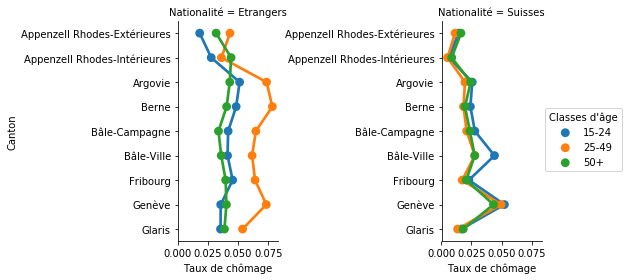

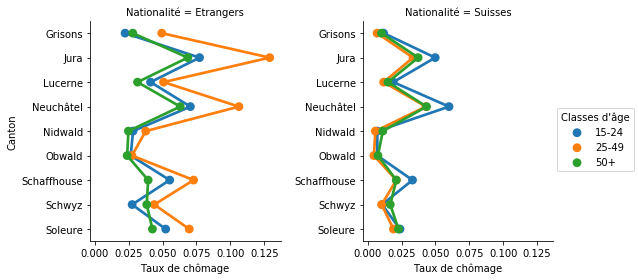

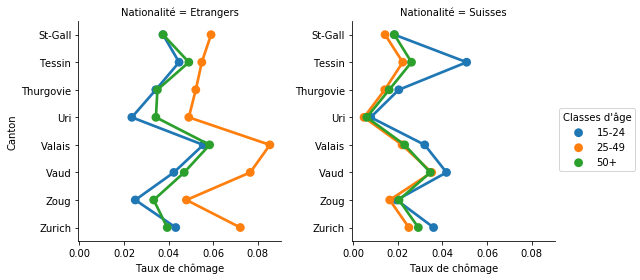

In [56]:
sns.factorplot(x="Taux de chômage", y="Canton", hue="Classes d\'âge", col='Nationalité', data=formatted_table[:54])
sns.factorplot(x="Taux de chômage", y="Canton", hue="Classes d\'âge", col='Nationalité', data=formatted_table[54:108])
sns.factorplot(x="Taux de chômage", y="Canton", hue="Classes d\'âge", col='Nationalité', data=formatted_table[108:])
plt.show()

From the above it can be easily observed that even though there is difference in the unemployment rates between Suisses and Etrangers in every age category it is most present in the 25-49 age group, independent of the canton. This result can be somehow explained with the fact that the number of younger Etrangers is lower, and their attempt to "fit" in the society's mechanism (find a job, if looking) easier, due to their age. On the other side, their older kin is more numerous and less flexible, hence their quest for a job a bit harder.

## Task 4: (BONUS) Estimation of the difference in unemployment rates between the areas divided by the Röstigraben

The data used in the second task represents the unemployement rate for every canton, hence it perfectly fits the needs of this exercise.

Inspecting the maps generated previously, a trend in which the eastern part of Switzerland has lower unemployemend than the west can be easily observed, suggesting that there is some difference between the areas divided by the Röstigraben. To test this hypothesis we split the data into three groups:
* french-speaking cantons (Geneva, Vaud, Neuchâtel)
* german-speaking cantons (Aargau, Appenzell Ausserrhoden, Appenzell Innerrhoden, Basel-Stadt, Basel-Landschaft, Lucerne, Nidwalden, Obwalden, Schaffhausen, Schwyz, Solothurn, St. Gallen, Thurgau, Uri, Zug, Zurich)
* mixed (Fribourg, Valais, Bern)

We remove Glarus since it is influenced by the italian population, in order to have a clearer picture of the difference between the populations on the border of the Röstigraben.

In [57]:
german_cantons = ['AG', 'AR', 'AI', 'BS', 'BL', 'LU', 'NW', 'OW', 'SH', 'SZ', 'SO', 'SG', 'TG', 'UR', 'ZG', 'ZH']
french_cantons = ['GE', 'VD',  'NE', 'JU']
mixed_cantons = ['FR', 'BE', 'VS']

mixed_data = map_data.loc[map_data['Id'].isin(mixed_cantons)]
french_data = map_data.loc[map_data['Id'].isin(french_cantons)]
german_data = map_data.loc[map_data['Id'].isin(german_cantons)]

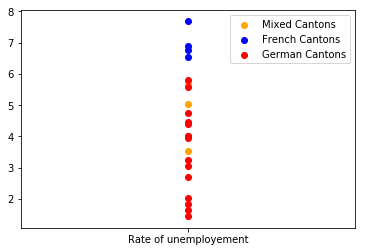

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.zeros(3), mixed_data["Taux de chômage tous"], color='orange', label='Mixed Cantons')
ax.scatter(np.zeros(french_data.shape[0]), french_data["Taux de chômage tous"], color='blue', label = 'French Cantons')
ax.scatter(np.zeros(german_data.shape[0]), german_data["Taux de chômage tous"], color='red', label = 'German Cantons')
ax.legend()
ax.set_xticks([0])
ax.set_xticklabels(['Rate of unemployement'])
plt.show()

The previous plot, supports our hypothesis and it is more then evident that the German speaking cantons tend to have lower unemployement rate than the French ones, while the cantons where the population is mixed are positioned somewhere in the middle.